# Introducion

In [ ]:
"""

With the rise of wearable tech in an ever more connected and data driven world
there is a gap in information collection around the weightroom. The following
project is designed to provide an investigatory look at the implementation of
machine learning to categorize the motion for common weightroom exercises.

The motion of a barbell, used to perform curls, squats, deadlifts and bench
presses, will be tracked using an Arduino Nano 33 Sense Rev 2 board. The data
collected will then be cleaned, smoothed, segmented, and scaled. Next statistical
data will be calculated for each repetition and a label will be applied to
indicate the lift that corresponds to the repetition. Finally the statistical
data will be used to train a machine learning model which will then categorize
the test data based on its training. The data involved in this project is
original and was generated by the project author.

This is a multiclassification problem that will involve a small set of tabulated
numerical data. As such the primary machine learning model being considered is
random forest.


"""

# Data and Library Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""

The data was collected using an Arduino Nano Board mounted to a barbell. The
collection was done over several sets with a varying number of repetitions. The
data is in a tabulated form and contains numerical values. The data was
collected at a rate of 200hz. A total of 400 reps were completed with each
exercise contributing 100 reps. The average rep time was approximately 2 seconds
for a total of around 160k data samples across 4 exercises. The information
collected during each sample includes acceleration, gyroscope, and magnetometer
readings across the x, y, and z directions.


"""

In [3]:
curl_A = pd.read_csv('/content/drive/My Drive/CSCA 5622/curl_20reps_200hz_A.csv')
curl_B = pd.read_csv('/content/drive/My Drive/CSCA 5622/curl_20reps_200hz_B.csv')
curl_C = pd.read_csv('/content/drive/My Drive/CSCA 5622/curl_60reps_200hz_C.csv')
squat_A = pd.read_csv('/content/drive/My Drive/CSCA 5622/squat_20reps_200hz_A.csv')
squat_B = pd.read_csv('/content/drive/My Drive/CSCA 5622/squat_20reps_200hz_B.csv')
squat_C = pd.read_csv('/content/drive/My Drive/CSCA 5622/squat_20reps_200hz_C.csv')
squat_D = pd.read_csv('/content/drive/My Drive/CSCA 5622/squat_20reps_200hz_D.csv')
squat_E = pd.read_csv('/content/drive/My Drive/CSCA 5622/squat_20reps_200hz_E.csv')
deadlift_A = pd.read_csv('/content/drive/My Drive/CSCA 5622/deadlift_20reps_200hz_A.csv')
deadlift_B = pd.read_csv('/content/drive/My Drive/CSCA 5622/deadlift_20reps_200hz_B.csv')
deadlift_C = pd.read_csv('/content/drive/My Drive/CSCA 5622/deadlift_20reps_200hz_C.csv')
deadlift_D = pd.read_csv('/content/drive/My Drive/CSCA 5622/deadlift_20reps_200hz_D.csv')
deadlift_E = pd.read_csv('/content/drive/My Drive/CSCA 5622/deadlift_20reps_200hz_E.csv')
bench = pd.read_csv('/content/drive/My Drive/CSCA 5622/bench_100reps_200hz_A.csv')

# Basic Frame Cleaning

In [4]:
"""

This project focuses on the acceleration in the Z direction. Gyroscope and
magnetometer data is removed for clarity.

"""

lifts = [curl_A, curl_B, curl_C, squat_A, squat_B, squat_C, squat_D, squat_E, deadlift_A,
 deadlift_B, deadlift_C, deadlift_D, deadlift_E, bench]

to_drop = ['Gx', 'Gy', 'Gz','rGx', 'rGy', 'rGz', 'Mx', 'My', 'Mz', 'rMx',
           'rMy', 'rMz', 'Roll', 'Pitch', 'Yaw']



for lift in lifts:
    lift.drop(columns=to_drop, inplace=True)

In [5]:
curl_A.head()

,Timestamp(ms),north,east,up,rAx,rAy,rAz
0,174486,-0.203813,-0.389861,-0.101921,-0.023437,-0.542358,0.872559
1,174519,-0.206527,-0.390655,-0.103605,-0.020142,-0.535522,0.834839
2,174553,-0.207980,-0.390998,-0.106090,-0.008057,-0.526001,0.824951
3,174585,-0.207658,-0.390835,-0.108615,0.005981,-0.497803,0.831543
4,174617,-0.205599,-0.389883,-0.109072,0.002686,-0.476685,0.874634


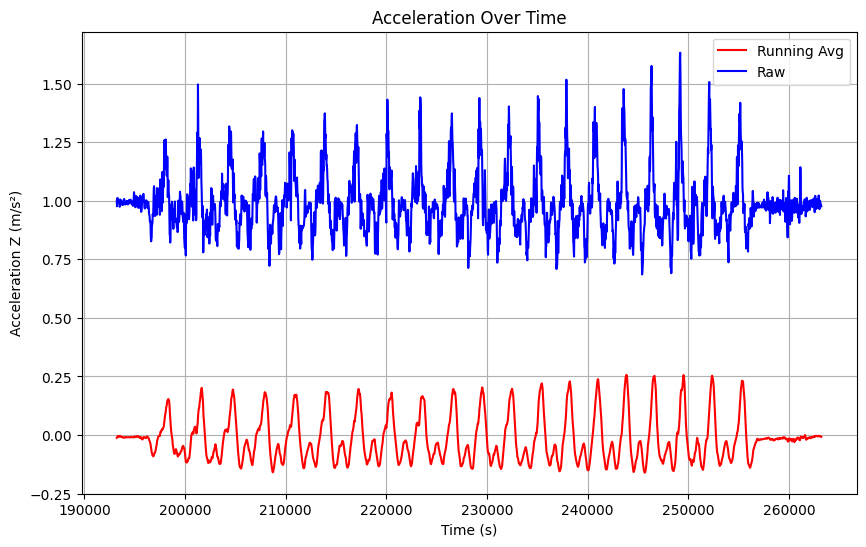

In [6]:
"""

Minimal processing of the data has been done during collection. The local frame
was transformed into a global frame, a running average was used to smooth the
global frame data, and the 1g acceleration due to gravity was removed.

"""

plt.figure(figsize=(10, 6))
plt.plot(squat_A['Timestamp(ms)'], squat_A['up'], label="Running Avg", color="red")
plt.plot(squat_A['Timestamp(ms)'], squat_A['rAz'], label="Raw", color="blue")

plt.xlabel("Time (s)")
plt.ylabel("Acceleration Z (m/s²)")
plt.title("Acceleration Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Functions

In [7]:
def shift_time(dataFrame):
    """
    Adjusts timestamps for the set to start at 0.

    Parameters:
        dataFrame (pd.DataFrame): The input dataframe with timestamps.

    Returns:
        pd.DataFrame: The modified dataframe with adjusted times.
    """
    dataFrame['time'] = (dataFrame['Timestamp(ms)'] - dataFrame['Timestamp(ms)'].iloc[0])/1000

In [8]:
def smooth_data(dataFrame):
    """
    Smooths the acceleration, gyroscope and magnetometer data.

    Parameters:
        dataFrame (pd.DataFrame): The input dataframe with columns 'north',
        'east', 'up'.

        columns 'Gx', 'Gy', 'Gz','rGx', 'rGy', 'rGz', 'Mx', 'My', 'Mz', 'rMx',
           'rMy', 'rMz', 'Roll', 'Pitch', 'Yaw', may have use in future iterations

    Returns:
        pd.DataFrame: The modified dataframe with filtered data.
    """
    for col in ['north', 'east', 'up']:
        dataFrame[f'{col}Sm'] = gaussian_filter1d(dataFrame[col], sigma=8)

In [9]:
def plot_z_acc(x, y):

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="Acceleration", color="blue")

    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration Z (m/s²)")
    plt.title("Acceleration Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def get_cycles(dataFrame, peaks):
    """
    Adjusts timestamps for each cycle to start at 0.

    Parameters:
        dataFrame (pd.DataFrame): The input dataframe with timestamps.
        peaks (list): Indices of the start of each cycle.

    Returns:
        pd.DataFrame: The modified dataframe with adjusted timestamps.
    """

    adj_dataFrame = dataFrame.copy()

    for i in range(len(peaks)):
        start_idx = peaks[i]
        end_idx = peaks[i + 1] if i + 1 < len(peaks) else len(dataFrame)
        cycle_start_time = adj_dataFrame.loc[start_idx, 'time']
        adj_dataFrame.loc[start_idx:end_idx-1, 'time'] -= cycle_start_time
    dataFrame['cycles'] = adj_dataFrame['time']


In [11]:
def integrate(time, qty):
    """
    Integrates a quantity with respect to time.

    Parameters:
        time: Timeframe over which to integrate.
        qty: The quantity being integrated

    Returns:
        integrated: The quantity modified with respect to time.
    """
    integrated = time * qty
    return integrated

In [12]:
def rms(series):
    """
    Returns the root mean square value for a given series of data.
    """
    return np.sqrt(np.mean(series**2))

In [13]:
def stats(dataFrame, peaks, col, exercise_label="Unknown"):
    """
    Adjusts timestamps for the set to start at 0.

    Parameters:
        dataFrame (pd.DataFrame): The input dataframe.
        list: List of peak values for a given set
        col: List of column names
        Exercise Label: A string identifying the exercise

    Returns:
        pd.DataFrame: A new dataframe containing the statistical values for the
                      acceleration, velocity, and distance in the Z direction
                      and the rep time.
    """

    exercise_stats = []
    peaks = peaks[1:-1]

    for rep_id in range(len(peaks) - 1):

        peak_0 = peaks[rep_id]
        peak_1 = peaks[rep_id + 1]

        # Ensure slicing uses the original index
        cycle_dataFrame = dataFrame.loc[peak_0:peak_1].copy()

        # Calculate statistics
        start = cycle_dataFrame['cycles'].iloc[0]
        end = cycle_dataFrame['cycles'].iloc[-1]

        rep_time = cycle_dataFrame['time'][peak_1] - cycle_dataFrame['time'][peak_0]

        statistics = cycle_dataFrame[col].agg(['mean', 'median', 'var',
                                                         'std', 'max', 'min']).T
        statistics['rms'] = [
            rms(cycle_dataFrame[series])
            for series in col]

        rep_stats = statistics.to_dict(orient='index')
        flat_stats = {f"{feature}_{stat}": value for feature, stat_values in rep_stats.items() for stat, value in stat_values.items()}


        flat_stats['rep_time'] = rep_time
        flat_stats['exercise_label'] = exercise_label

        exercise_stats.append(flat_stats)

        # Convert list of dictionaries to a single DataFrame
        processed_df = pd.DataFrame(exercise_stats)

    return processed_df

In [14]:
def plot_peaks(x, y, peaks):
    plt.figure(figsize=(10, 6))

    plt.plot(x, y, color="blue")

    # Adding vertical lines
    for i in range(len(peaks)):
        plt.axvline(x[peaks[i]], color='r', linestyle='--')

# Curls

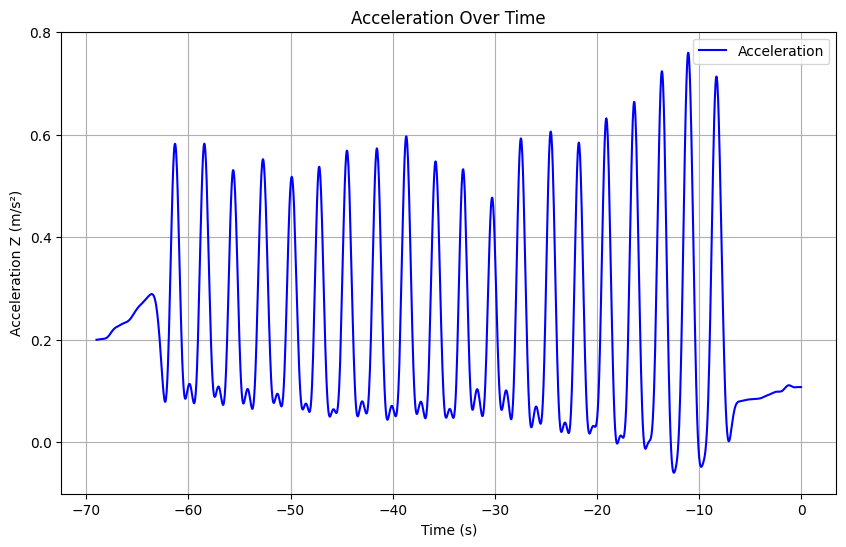

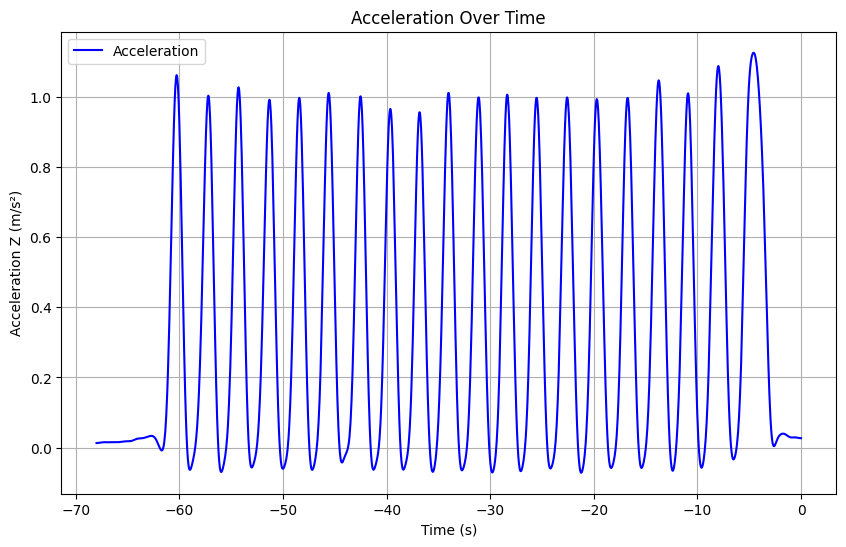

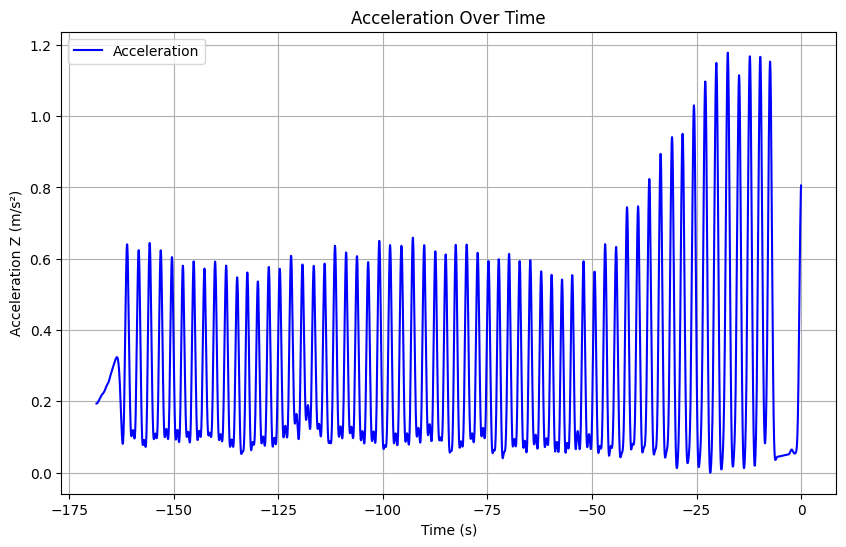

In [15]:
"""
For each set of curl data:

    Adjust the time to start at 0. This shifts all of the sets into the same frame
    of reference in terms of time. Useful when comparing data from multiple sets
    with respect to time.

    Smooth the data using a gaussian filter. The smoothing helps to identify
    repetitions or cycles more clearly.

    Plot the acceleration in the Up direction to visually inspect the data.
"""

curls = [-curl_A, -curl_B, -curl_C]
sets = len(curls)

for curl in curls:
    shift_time(curl)
    smooth_data(curl)
    plot_z_acc(curl['time'], curl['upSm'])

In [16]:
"""
Segment the data by:

    Identifing a height threshhold for peak values
    Storing the peak indexes and heights in peaks_cl
    Use the peaks to create identify the start and end of each rep

"""

peaks_cl = []
h = [0.4, 0.8, 0.05]
for i in range(sets):
    peaks, _ = find_peaks(curls[i]['upSm'], height=h[i])
    peaks_cl.append(peaks)
    get_cycles(curls[i], peaks)

In [17]:
"""

Integrate to find velocity and disttance in the Up direction

"""
for curl in curls:
    curl['v_up'] = integrate(curl['cycles'], curl['upSm'])
    curl['d_up'] = integrate(curl['cycles'], curl['v_up'])

In [18]:
"""
To increase the uniformity of the data:

    Trim the data frame to begin at the second rep in the set and end at the
    peak of the final rep. Trimming eliminates noise from beginning and
    ending reps
"""

trimmed_frames = []
for i in range(sets):
    trim_frame = curls[i].iloc[peaks_cl[i][1]:peaks_cl[i][-1]].copy()
    trimmed_frames.append(trim_frame)

In [19]:
"""
Scale the data:

    Scaling the data will be useful as the sample size increases with data from
    individuals of varying abilities and sizes
"""

for frame in trimmed_frames:
    frame['scaled_upSm'] = (frame['upSm'] - np.min(frame['upSm'])) / (np.max(frame['upSm']) - np.min(frame['upSm']))
    frame['scaled_v'] = (frame['v_up'] - np.min(frame['v_up'])) / (np.max(frame['v_up']) - np.min(frame['v_up']))
    frame['scaled_d'] = (frame['d_up'] - np.min(frame['d_up'])) / (np.max(frame['d_up']) - np.min(frame['d_up']))

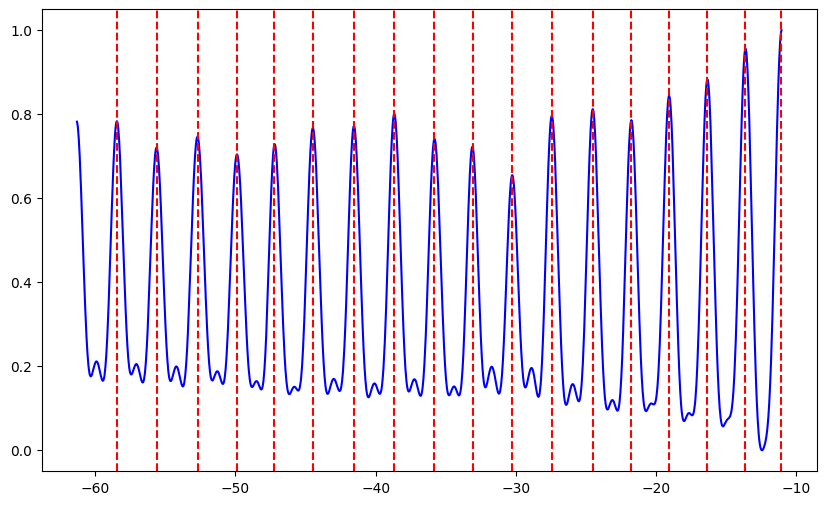

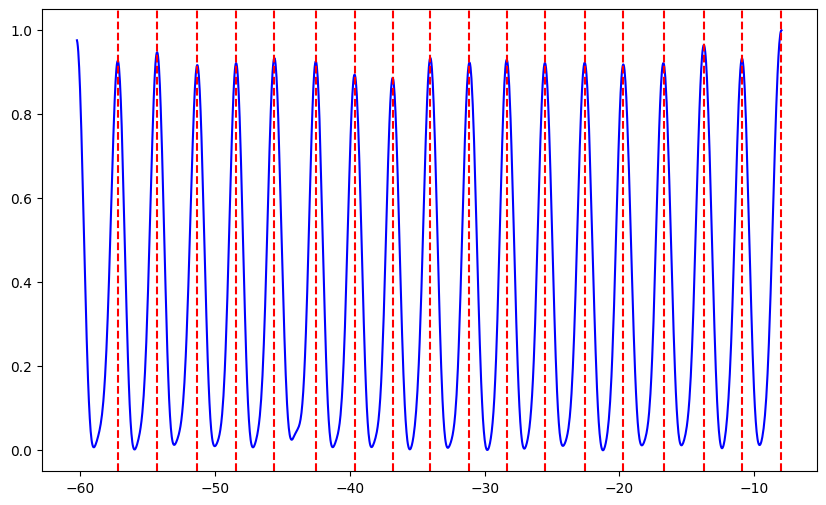

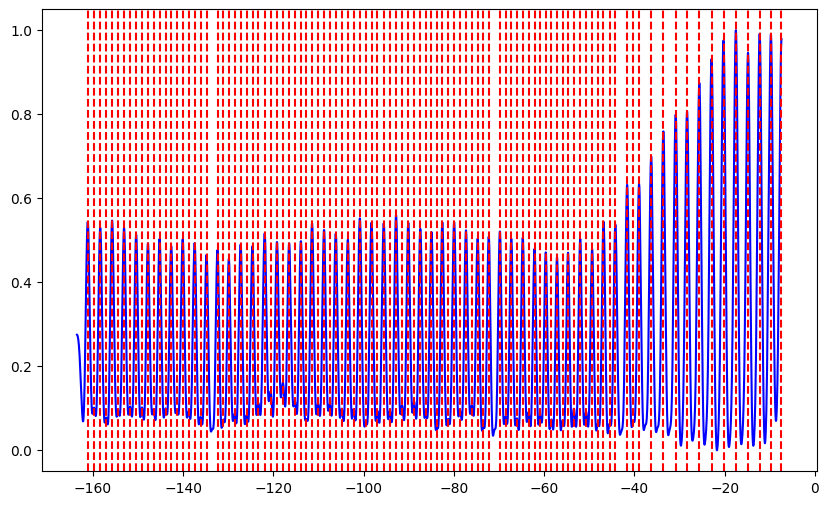

In [20]:
"""
    Plot the scaled acceleration values and peak values.
    Visually confirm that the reps are being segmented correctly.
"""

for i, frame in enumerate(trimmed_frames):
    peaks = peaks_cl[i]
    p = peaks[1:-1]
    plot_peaks(frame['time'], frame['scaled_upSm'], p)

In [21]:
"""
Calculate statistics for each rep in each set with respect to the acceleration
velocity, and distance in the up direction.

Add the exercise label and concatenate the set dataframes.
"""

curl_stats = [stats(frame, peaks_cl[i], ['scaled_upSm', 'scaled_v', 'scaled_d'], 'curls') for i, frame in enumerate(trimmed_frames)]

curl_stats_df = pd.concat(curl_stats, ignore_index=True)

curl_stats_df['rep_time'] = -curl_stats_df['rep_time']

In [22]:
curl_stats_df.tail()

,scaled_upSm_mean,scaled_upSm_median,scaled_upSm_var,scaled_upSm_std,scaled_upSm_max,scaled_upSm_min,scaled_upSm_rms,scaled_v_mean,scaled_v_median,scaled_v_var,...,scaled_v_rms,scaled_d_mean,scaled_d_median,scaled_d_var,scaled_d_std,scaled_d_max,scaled_d_min,scaled_d_rms,rep_time,exercise_label
132,0.242458,0.158230,0.030736,0.175316,0.546859,0.079882,0.298005,0.918261,0.964466,0.008257,...,0.922642,0.032312,0.008684,0.001819,0.042651,0.138611,0.000072,0.053112,1.379,curls
133,0.226786,0.139017,0.032072,0.179088,0.546859,0.061633,0.287615,0.968838,0.968910,0.000160,...,0.968918,0.007339,0.007757,0.000019,0.004334,0.017584,0.000072,0.008496,1.305,curls
134,0.229478,0.152220,0.030009,0.173231,0.529920,0.066023,0.286247,0.925734,0.967990,0.006954,...,0.929391,0.027982,0.007427,0.001373,0.037061,0.120489,0.000072,0.046075,1.312,curls
135,0.233626,0.146282,0.027561,0.166016,0.529920,0.081441,0.285510,0.962908,0.960984,0.000182,...,0.963000,0.010019,0.009817,0.000046,0.006781,0.026563,0.000072,0.012055,1.403,curls
136,0.252167,0.177271,0.029730,0.172424,0.543757,0.086822,0.304346,0.916124,0.960196,0.008194,...,0.920482,0.032813,0.009665,0.001798,0.042400,0.137157,0.000072,0.053223,1.377,curls


In [23]:
"""

The data for the other exercises was cleaned in a similar manner.

"""

'\n\nThe data for the other exercises was cleaned in a similar manner.\n\n'

# Squats

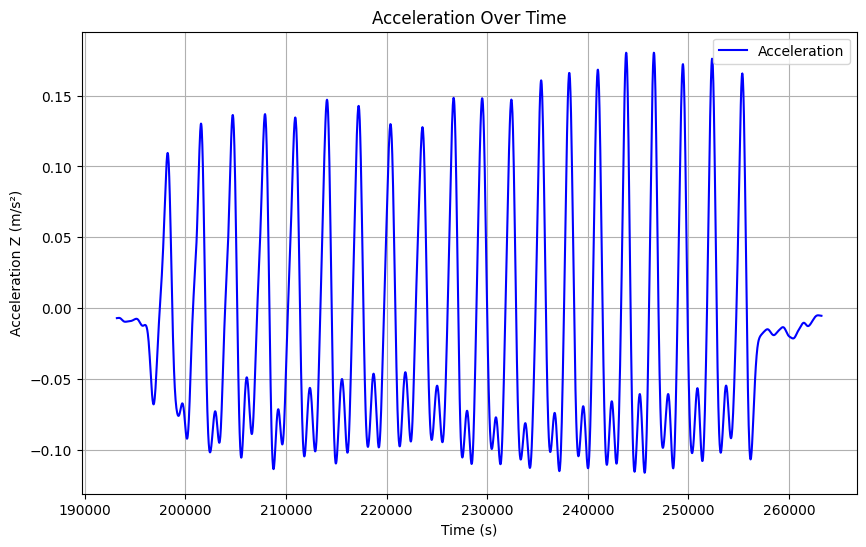

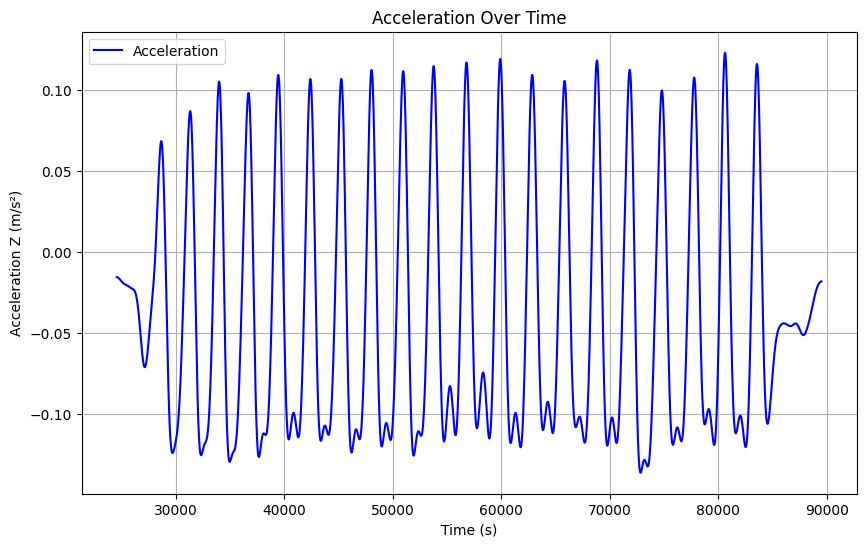

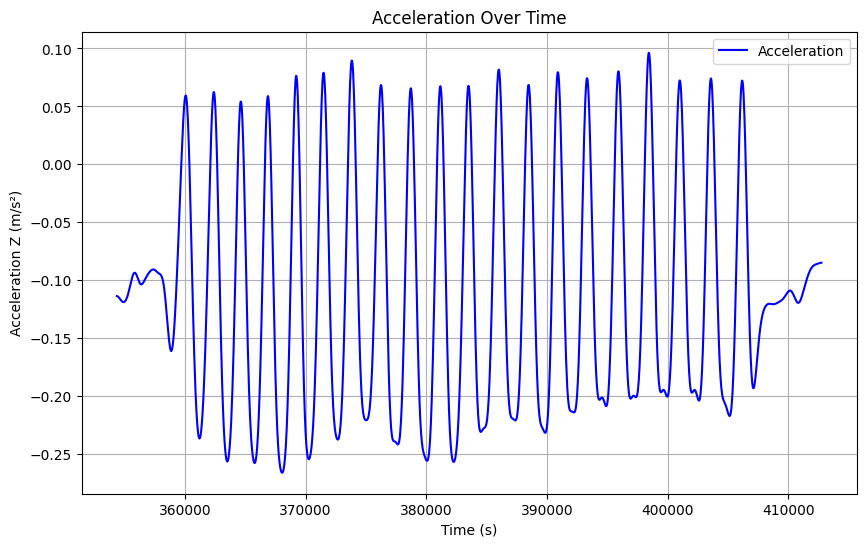

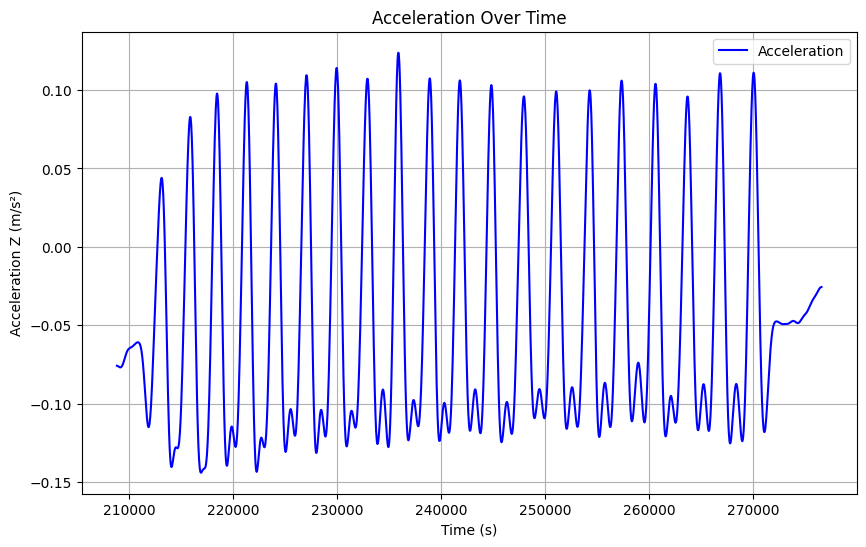

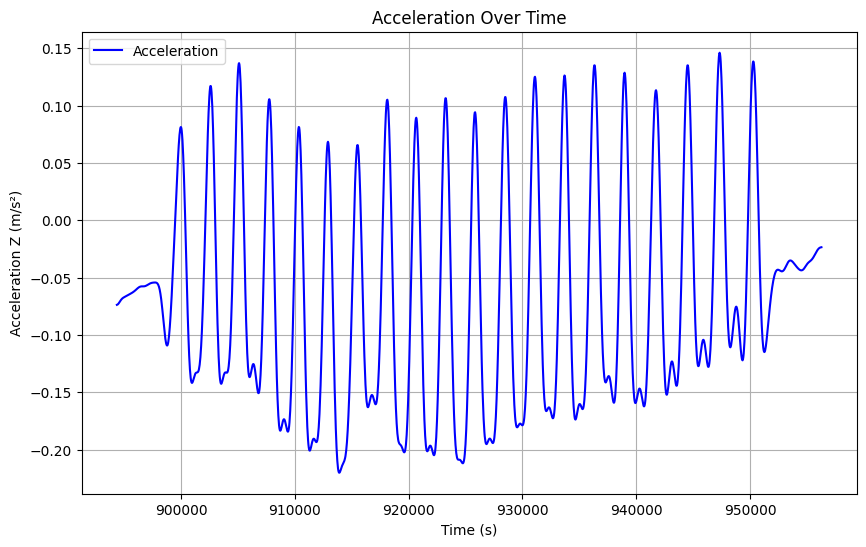

In [24]:
# For each set of squat data:
    # Adjust the time to start at 0
    # Smooth the acceleration data
    # Plot the acceleration in the Up direction

squats = [squat_A, squat_B, squat_C, squat_D, squat_E]
sets = len(squats)

for squat in squats:
    shift_time(squat)
    smooth_data(squat)
    plot_z_acc(squat['Timestamp(ms)'], squat['upSm'])

In [25]:
# For each set of squat data:
    # Identify a height threshhold for peak values
    # Store the peak indexes and heights in peaks_cl
    # Using the peaks identify each rep using get_cycles

peaks_sq = []
h = [0.1, 0.05, 0.05, 0.025, 0.05]
for i in range(sets):
    peaks, _ = find_peaks(squats[i]['upSm'], height=h[i])
    peaks_sq.append(peaks)
    get_cycles(squats[i], peaks)


In [26]:
# For each set of squat data:
    # Integrate to find velocity and disttance in the Up direction

for squat in squats:
    squat['v_up'] = integrate(squat['cycles'], squat['upSm'])
    squat['d_up'] = integrate(squat['cycles'], squat['v_up'])

In [27]:
# For each set of squat data:
    # Trim the data frame to begin at the second rep in the set and end at the
    # peak of the final rep. Trimming eliminates noise from beginning and
    # ending reps

trimmed_frames = []
for i in range(sets):
    trim_frame = squats[i].iloc[peaks_sq[i][1]:peaks_sq[i][-1]].copy()
    trimmed_frames.append(trim_frame)


In [28]:
# For each set of trimmed squat data:
    # Scale the data to values between 0 and 1

for frame in trimmed_frames:
    frame['scaled_upSm'] = (frame['upSm'] - np.min(frame['upSm'])) / (np.max(frame['upSm']) - np.min(frame['upSm']))
    frame['scaled_v'] = (frame['v_up'] - np.min(frame['v_up'])) / (np.max(frame['v_up']) - np.min(frame['v_up']))
    frame['scaled_d'] = (frame['d_up'] - np.min(frame['d_up'])) / (np.max(frame['d_up']) - np.min(frame['d_up']))

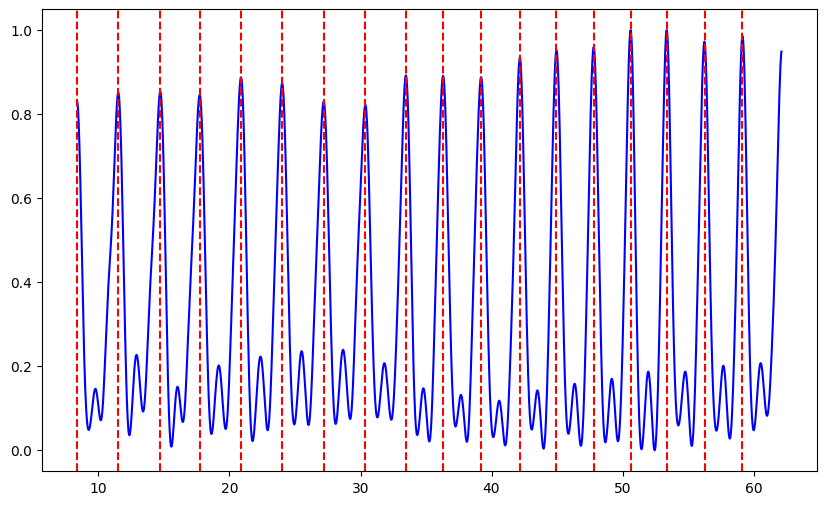

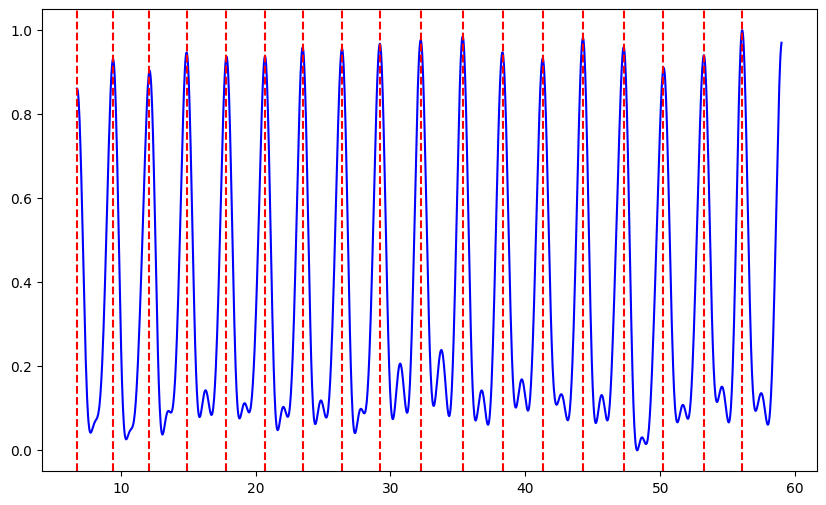

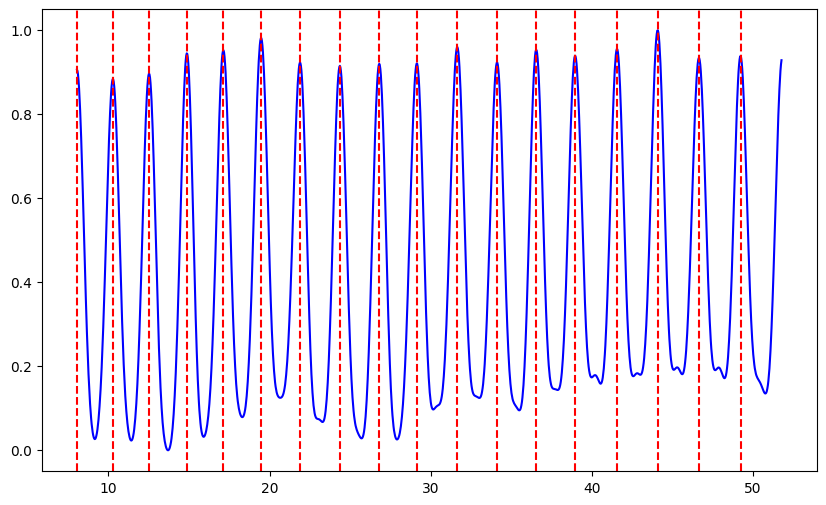

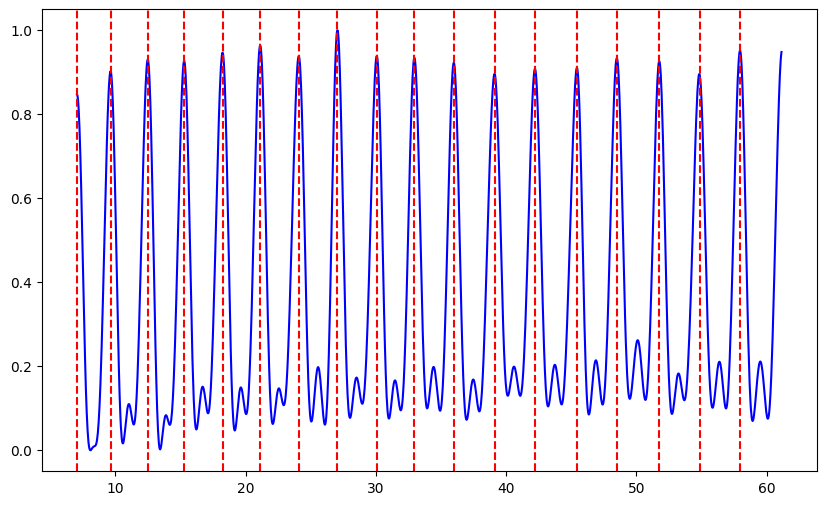

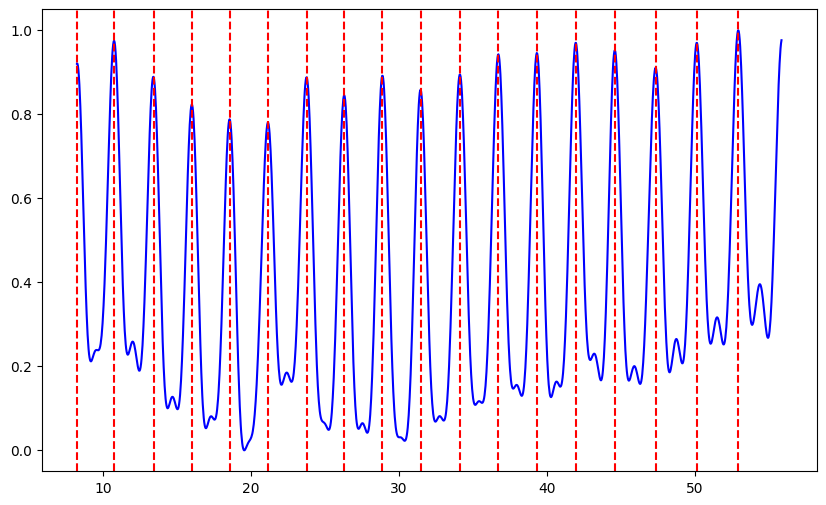

In [29]:
# For each set of trimmed squat data:
    # Plot the scaled acceleration values and peak values
    # Visually confirm that the reps are being segmented correctly

for i, frame in enumerate(trimmed_frames):
    peaks = peaks_sq[i]
    p = peaks[1:-1]
    plot_peaks(frame['time'], frame['scaled_upSm'], p)

In [30]:
# For each set of curl data:
    # Calculate the statistical values for acceleration, velocity and distance
    # in the Z direction
    # Concatenate the set dataframes

squat_stats = [stats(frame, peaks_sq[i], ['scaled_upSm', 'scaled_v', 'scaled_d'], 'squats') for i, frame in enumerate(trimmed_frames)]

squat_stats_df = pd.concat(squat_stats, ignore_index=True)

In [31]:
squat_stats_df.head()

,scaled_upSm_mean,scaled_upSm_median,scaled_upSm_var,scaled_upSm_std,scaled_upSm_max,scaled_upSm_min,scaled_upSm_rms,scaled_v_mean,scaled_v_median,scaled_v_var,...,scaled_v_rms,scaled_d_mean,scaled_d_median,scaled_d_var,scaled_d_std,scaled_d_max,scaled_d_min,scaled_d_rms,rep_time,exercise_label
0,0.335972,0.223536,0.072989,0.270164,0.851768,0.048407,0.430422,0.287880,0.226035,0.040857,...,0.351276,0.251862,0.201971,0.038709,0.196747,0.925461,0.054865,0.319098,3.158,squats
1,0.355678,0.227188,0.070343,0.265223,0.853737,0.035903,0.443033,0.299720,0.222497,0.041344,...,0.361718,0.260694,0.199018,0.041832,0.204529,0.952799,0.055382,0.330837,3.209,squats
2,0.340945,0.224622,0.080042,0.282917,0.853737,0.008555,0.442255,0.290809,0.229223,0.038733,...,0.350666,0.251955,0.202658,0.032747,0.180961,0.848279,0.071841,0.309747,3.000,squats
3,0.341570,0.199691,0.080500,0.283725,0.888119,0.038881,0.443289,0.284488,0.198317,0.049088,...,0.360022,0.247936,0.188589,0.048060,0.219226,0.978672,0.011744,0.330356,3.154,squats
4,0.338067,0.213255,0.082807,0.287762,0.888119,0.022079,0.443184,0.278140,0.202890,0.046955,...,0.352035,0.241265,0.183910,0.045827,0.214072,0.955206,0.000000,0.321958,3.148,squats


# Deadlifts

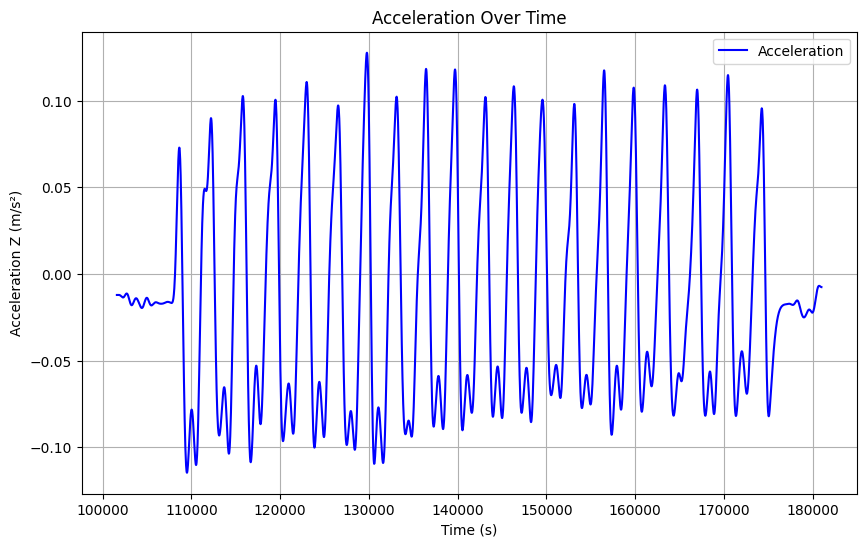

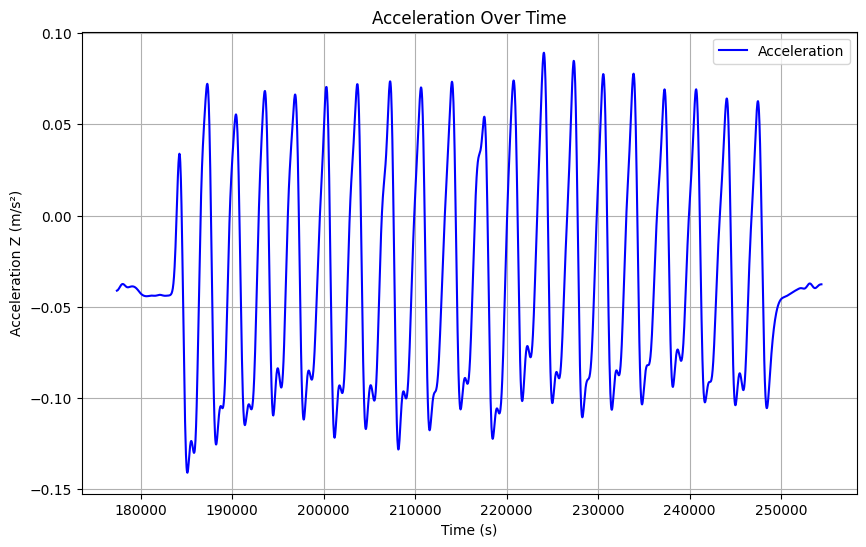

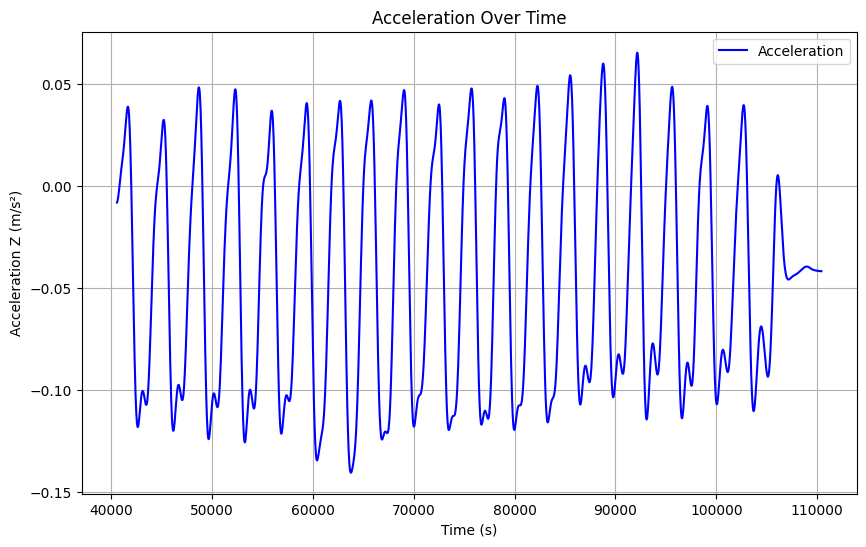

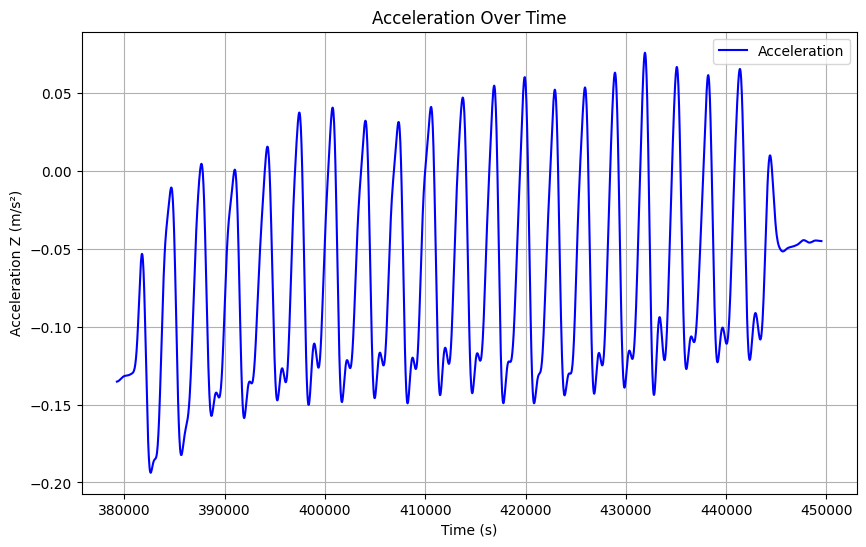

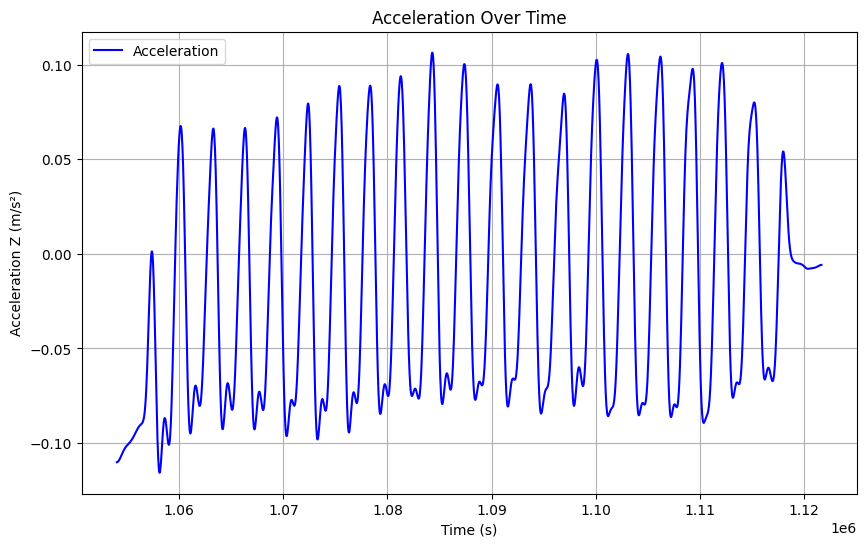

In [32]:
deadlifts = [deadlift_A, deadlift_B, deadlift_C, deadlift_D, deadlift_E]
sets = len(deadlifts)

for deadlift in deadlifts:
    shift_time(deadlift)
    smooth_data(deadlift)
    plot_z_acc(deadlift['Timestamp(ms)'], deadlift['upSm'])

In [33]:
peaks_dl = []
h = [0.06, 0.05, 0.02, -0.02, 0.05]
for i in range(sets):
    peaks, _ = find_peaks(deadlifts[i]['upSm'], height=h[i])
    peaks_dl.append(peaks)
    get_cycles(deadlifts[i], peaks)

In [34]:
for deadlift in deadlifts:
    deadlift['v_up'] = integrate(deadlift['cycles'], deadlift['upSm'])
    deadlift['d_up'] = integrate(deadlift['cycles'], deadlift['v_up'])

In [35]:
trimmed_frames = []
for i in range(sets):
    trim_frame = deadlifts[i].iloc[peaks_dl[i][1]:peaks_dl[i][-1]].copy()
    trimmed_frames.append(trim_frame)

In [36]:
for frame in trimmed_frames:
    frame['scaled_upSm'] = (frame['upSm'] - np.min(frame['upSm'])) / (np.max(frame['upSm']) - np.min(frame['upSm']))
    frame['scaled_v'] = (frame['v_up'] - np.min(frame['v_up'])) / (np.max(frame['v_up']) - np.min(frame['v_up']))
    frame['scaled_d'] = (frame['d_up'] - np.min(frame['d_up'])) / (np.max(frame['d_up']) - np.min(frame['d_up']))

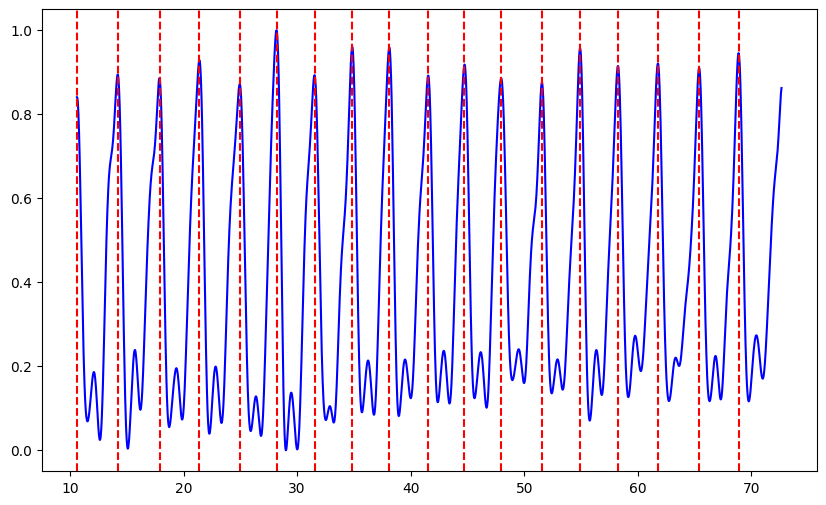

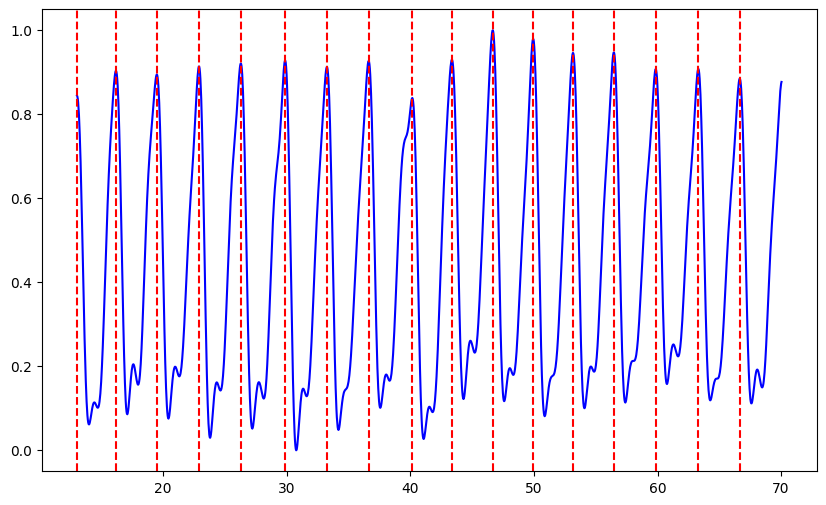

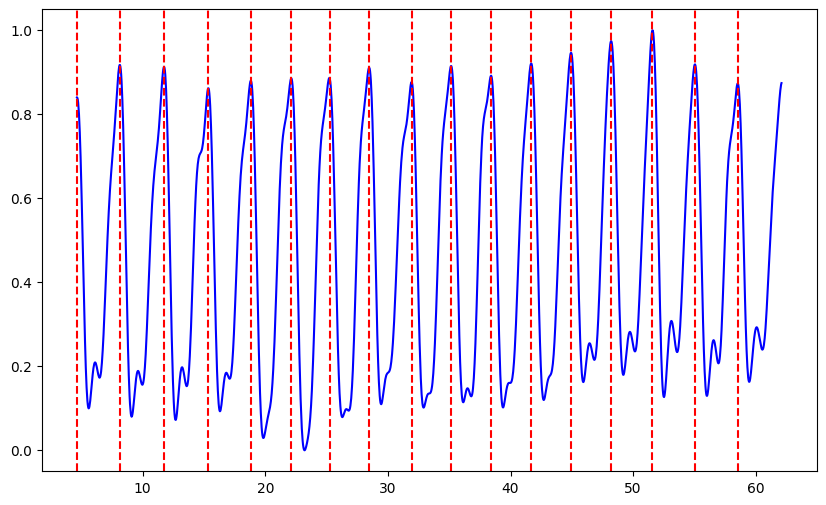

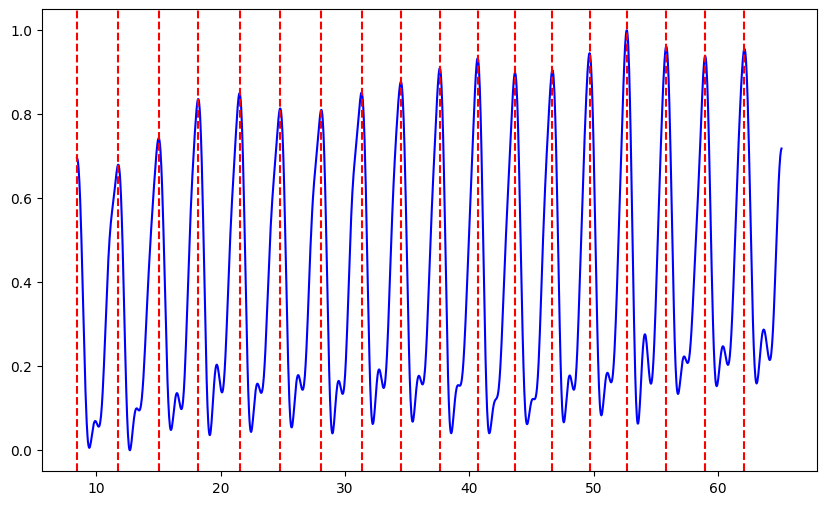

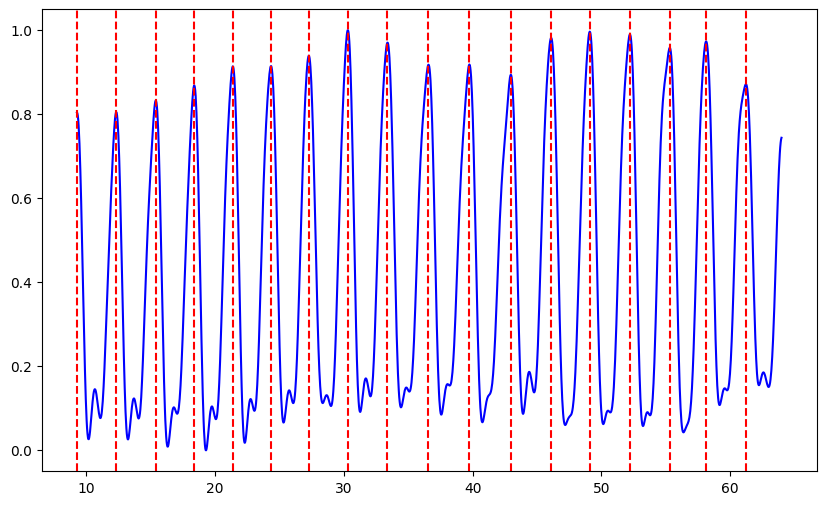

In [37]:
for i, frame in enumerate(trimmed_frames):
    peaks = peaks_dl[i]
    p = peaks[1:-1]
    plot_peaks(frame['time'], frame['scaled_upSm'], p)

In [38]:
deadlift_stats = [stats(frame, peaks_dl[i], ['scaled_upSm', 'scaled_v', 'scaled_d'], 'deadlifts') for i, frame in enumerate(trimmed_frames)]

deadlift_stats_df = pd.concat(deadlift_stats, ignore_index=True)

In [39]:
deadlift_stats_df.head()

,scaled_upSm_mean,scaled_upSm_median,scaled_upSm_var,scaled_upSm_std,scaled_upSm_max,scaled_upSm_min,scaled_upSm_rms,scaled_v_mean,scaled_v_median,scaled_v_var,...,scaled_v_rms,scaled_d_mean,scaled_d_median,scaled_d_var,scaled_d_std,scaled_d_max,scaled_d_min,scaled_d_rms,rep_time,exercise_label
0,0.383797,0.260477,0.089081,0.298465,0.894480,0.024649,0.485521,0.327627,0.265123,0.057509,...,0.405499,0.280660,0.221436,0.051965,0.227958,0.958565,0.000000,0.361048,3.604,deadlifts
1,0.398134,0.300212,0.083870,0.289603,0.894480,0.003853,0.491713,0.338370,0.266506,0.049103,...,0.404037,0.288953,0.221162,0.047056,0.216923,0.969874,0.048189,0.360851,3.671,deadlifts
2,0.383162,0.227157,0.088785,0.297967,0.928848,0.055180,0.484701,0.324765,0.243937,0.054625,...,0.399612,0.275793,0.212813,0.049831,0.223229,0.973722,0.032466,0.354290,3.512,deadlifts
3,0.392223,0.275439,0.087942,0.296550,0.928848,0.039412,0.491049,0.324015,0.261606,0.047126,...,0.389567,0.273034,0.218076,0.041334,0.203307,0.894428,0.037273,0.339964,3.541,deadlifts
4,0.381648,0.241965,0.109376,0.330721,1.000000,0.034085,0.504132,0.317529,0.247310,0.062319,...,0.403287,0.267357,0.211706,0.049609,0.222730,0.964120,0.033530,0.347403,3.250,deadlifts


# Bench Press

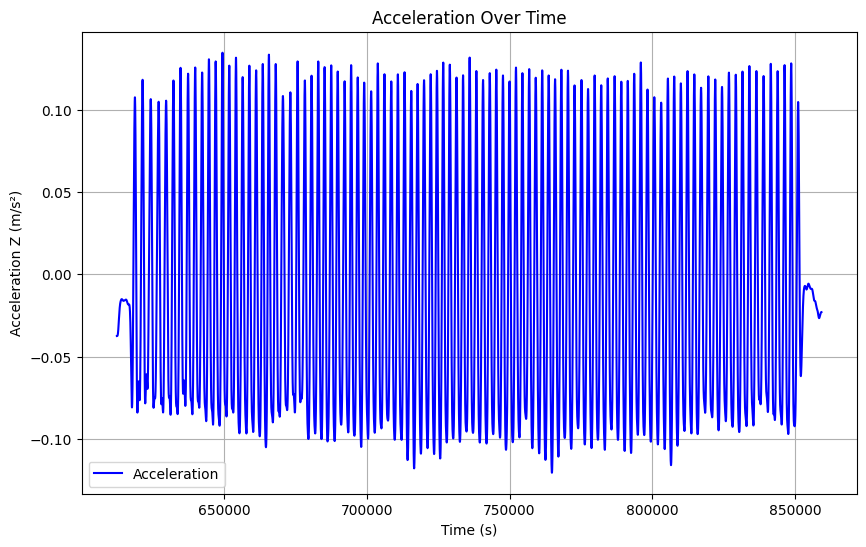

In [40]:
shift_time(bench)
smooth_data(bench)
plot_z_acc(bench['Timestamp(ms)'], bench['upSm'])

In [41]:
peaks_b, peak_heights = find_peaks(bench['upSm'], height = 0.1)

In [42]:
print(len(peaks_b))

99


In [43]:
get_cycles(bench, peaks_b)

In [44]:
bench['v_up'] = integrate(bench['cycles'], bench['upSm'])
bench['d_up'] = integrate(bench['cycles'], bench['v_up'])

In [45]:
trimmed_frame = bench.iloc[peaks_b[1]:peaks_b[-1]].copy()
trimmed_frame['scaled_upSm'] = (trimmed_frame['upSm'] - np.min(trimmed_frame['upSm'])) / (np.max(trimmed_frame['upSm']) - np.min(trimmed_frame['upSm']))
trimmed_frame['scaled_v'] = (trimmed_frame['v_up'] - np.min(trimmed_frame['v_up'])) / (np.max(trimmed_frame['v_up']) - np.min(trimmed_frame['v_up']))
trimmed_frame['scaled_d'] = (trimmed_frame['d_up'] - np.min(trimmed_frame['d_up'])) / (np.max(trimmed_frame['d_up']) - np.min(trimmed_frame['d_up']))

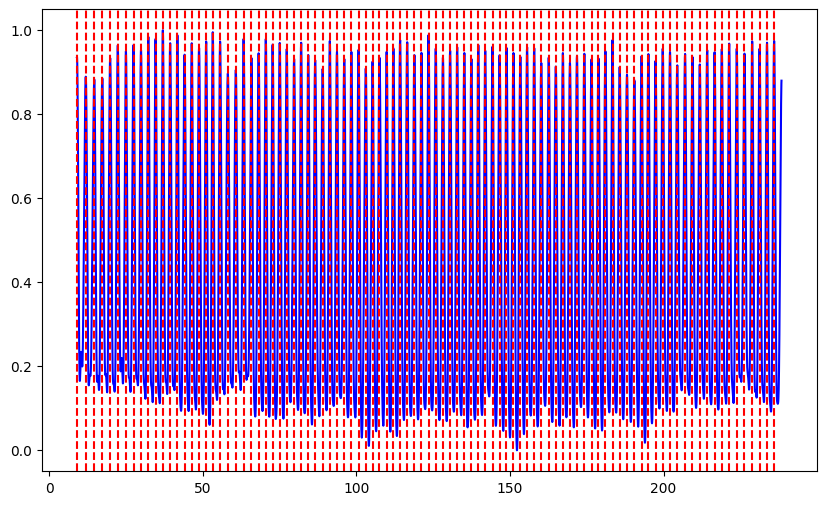

In [46]:
p = peaks_b[1:-1]
plot_peaks(trimmed_frame['time'], trimmed_frame['scaled_upSm'], p)

In [47]:
bench_stats_df = stats(trimmed_frame, peaks_b, ['scaled_upSm', 'scaled_v', 'scaled_d'], 'bench')

In [48]:
bench_stats_df.head()

,scaled_upSm_mean,scaled_upSm_median,scaled_upSm_var,scaled_upSm_std,scaled_upSm_max,scaled_upSm_min,scaled_upSm_rms,scaled_v_mean,scaled_v_median,scaled_v_var,...,scaled_v_rms,scaled_d_mean,scaled_d_median,scaled_d_var,scaled_d_std,scaled_d_max,scaled_d_min,scaled_d_rms,rep_time,exercise_label
0,0.460315,0.345409,0.074802,0.273499,0.935546,0.165077,0.534650,0.308290,0.242169,0.058381,...,0.390856,0.256142,0.195397,0.059014,0.242928,1.000000,0.020789,0.352079,2.875,bench
1,0.449657,0.374167,0.073096,0.270363,0.889475,0.154576,0.523868,0.304067,0.260016,0.053702,...,0.381489,0.251367,0.202618,0.048961,0.221272,0.934747,0.041892,0.334031,2.772,bench
2,0.431294,0.330936,0.076486,0.276560,0.885864,0.143501,0.511425,0.287618,0.241767,0.051900,...,0.366038,0.234999,0.196714,0.041923,0.204751,0.860405,0.022878,0.310853,2.619,bench
3,0.438899,0.341461,0.079761,0.282420,0.933833,0.137999,0.520945,0.286618,0.244839,0.053874,...,0.367889,0.231344,0.196740,0.042466,0.206073,0.891420,0.016994,0.308947,2.545,bench
4,0.450255,0.338365,0.090319,0.300531,0.964012,0.139545,0.540255,0.291779,0.247610,0.055830,...,0.374485,0.235035,0.200479,0.042236,0.205515,0.900998,0.033951,0.311335,2.485,bench


# Model Selection and Training

In [ ]:
"""
A random forest machine learning model was selected because of its robust
nature. Model bagging creates diversity among trees which helps model
generalization, random feature selection decorrelates features and prevents dominance
of strong predictors, and by providing feature importance the random forest
model offers insight into what features need not be included saving computational
time. Additionally, the ability of a random forest to handle multi-class
problems with small to medium data sets makes it a logical choice for this application.

The train and testing data is split using train test split and stratified
based on the exercise. The stratification ensures that class distridution is
respected and helps correct for data imbalance.



"""


In [49]:
# Combine exercise data frames
workout = pd.concat([curl_stats_df, squat_stats_df, deadlift_stats_df, bench_stats_df], ignore_index=True)

In [52]:
# Seperate features and lables
workout_x = workout.iloc[:, :-1]
workout_y = workout.iloc[:, -1]

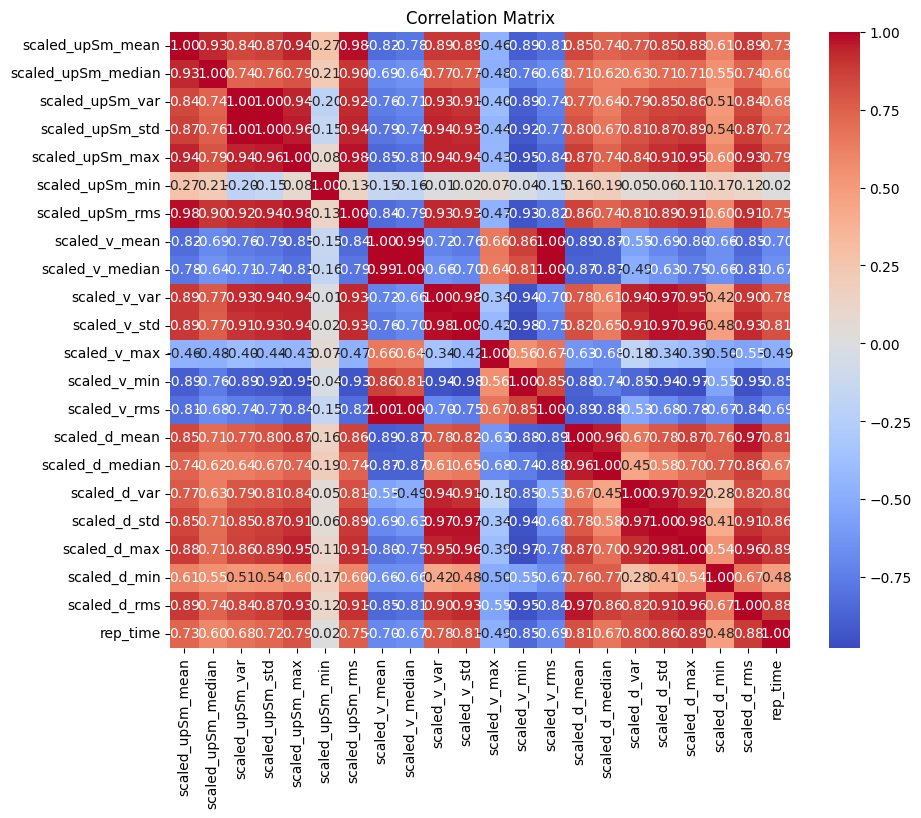

In [53]:
"""

The correlation matrix indicates a high degree of correlation in the data which
is in accordance with the fact that velocity and distance data are calculated
from acceleraion.

"""

corr_matrix = workout_x.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [54]:
# Seperate test and train data
train_X, test_X, train_y, test_y= train_test_split(workout_x, workout_y, test_size=0.2, random_state=42, stratify=workout['exercise_label'])

In [ ]:
"""

Perform a grid search to tune the hyperparameters. The grid search uses five
fold cross validation.

"""

In [ ]:
# Perform a grid search to identify the best parameters
terrain = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

lost_hiker = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=terrain,
                           cv=5,
                           scoring='accuracy')
lost_hiker.fit(train_X, train_y)

print("Best Path:", lost_hiker.best_params_)

Best Path: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [55]:
# Train Random Forest
sherwood = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=10, random_state=42)
sherwood.fit(train_X, train_y)

RandomForestClassifier(min_samples_split=10, random_state=42)

# Results

In [56]:
# Predict
pred_y = sherwood.predict(test_X)

# Evaluate
print("Accuracy:", accuracy_score(test_y, pred_y))

Accuracy: 0.9876543209876543


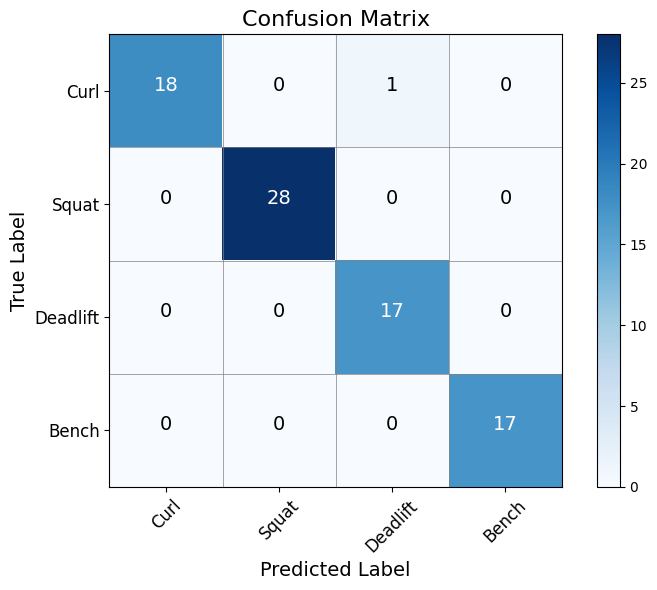

In [57]:
# Confusion matrix
dehydrated = confusion_matrix(test_y, pred_y)
classes = ['Curl', 'Squat', 'Deadlift', 'Bench']  # Labels for your classes

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot the confusion matrix as an image
plt.imshow(dehydrated, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=16)
plt.colorbar()

# Add labels to the axes
plt.xticks(np.arange(len(classes)), classes, rotation=45, fontsize=12)
plt.yticks(np.arange(len(classes)), classes, fontsize=12)

# Add grid lines for better readability
plt.grid(False)  # Turn off the default grid to avoid overlapping
plt.gca().set_xticks(np.arange(-0.5, len(classes)), minor=True)
plt.gca().set_yticks(np.arange(-0.5, len(classes)), minor=True)
plt.gca().grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
plt.gca().tick_params(which="minor", size=0)

# Annotate each cell with the confusion matrix value
thresh = dehydrated.max() / 2.0  # Set a threshold for text color
for i in range(dehydrated.shape[0]):
    for j in range(dehydrated.shape[1]):
        plt.text(j, i, f'{dehydrated[i, j]}',
                 horizontalalignment="center",
                 color="white" if dehydrated[i, j] > thresh else "black",
                 fontsize=14)

# Add axis labels
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [58]:
report = classification_report(test_y, pred_y)
print(report)

              precision    recall  f1-score   support

       bench       1.00      0.95      0.97        19
       curls       1.00      1.00      1.00        28
   deadlifts       0.94      1.00      0.97        17
      squats       1.00      1.00      1.00        17

    accuracy                           0.99        81
   macro avg       0.99      0.99      0.99        81
weighted avg       0.99      0.99      0.99        81



In [59]:
# Get feature importances
importances = sherwood.feature_importances_
feature_names = workout_x.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted features
print(sorted_feature_importance)

               Feature  Importance
14       scaled_d_mean    0.139935
21            rep_time    0.135512
7        scaled_v_mean    0.120837
13        scaled_v_rms    0.100716
15     scaled_d_median    0.100223
8      scaled_v_median    0.091033
20        scaled_d_rms    0.057825
1   scaled_upSm_median    0.049660
0     scaled_upSm_mean    0.039478
6      scaled_upSm_rms    0.028469
19        scaled_d_min    0.024925
10        scaled_v_std    0.015171
12        scaled_v_min    0.015120
3      scaled_upSm_std    0.013962
11        scaled_v_max    0.013368
2      scaled_upSm_var    0.010082
4      scaled_upSm_max    0.009487
16        scaled_d_var    0.008510
9         scaled_v_var    0.007863
5      scaled_upSm_min    0.006630
17        scaled_d_std    0.005674
18        scaled_d_max    0.005519


# Conclusion

In [ ]:
"""

The random forest model performs exceptionally well in this application with an overall
accuracy score of 98.8%. As seen in the classification report there are slight
imperfections in the 'deadlift' and 'bench' scores indicating room for improvement.
The accuracy of the model can be improved by implementing it in a more realistic setting.
In the instance above random single reps were being categorized using the model.
However, in a weightroom setting sets are comprised of multiple reps. using the model
to classify each rep from a given set and then selecting a label for the set based
on the majority of rep classifications will lead to an improved accuracy.

This project faced several limitations. Firstly, the data set was small and based
on the motion of a single individual performing the repetitions for each exercise.
A larger set that included motion data from individuals of varying sizes performing
the exercises at different rates would improve the flexibility of the model.
Second the number of exercises categorized was small. Ideally the model would be able
to recognize and differentiate a larger set of movements. Lastly the primary axis
of motion for each exercise is along the Z axis. Analyzing the motion along
multiple axis requires additional computational recourses.


"""

# github